#### Setting 

##### path 

In [193]:
data_dir = '../data/vital2'

ccb = pd.read_csv('../data/vital2/ccbccb.csv',encoding='cp949')
stb = pd.read_csv('../data/vital2/ccb_stb.csv',encoding='cp949')
oplist= pd.read_csv('../data/vital2/op_list1.csv',encoding='cp949')


##### delete missing file list (dd_all_simple) 

In [1]:
import pandas as pd
op1 = pd.read_csv('../data/vital2/dd_all_simple.csv',)

In [10]:
import os
dir_path = '../data/vital2/'

flist_ = os.listdir(dir_path)

flist_ = [ x for x in flist_ if x.endswith('.vital')]

In [17]:
missed = []
for x in op1.key:
    count = 0
    for file in flist_:
        if x.startswith(file[:15]):
            count += 1
    if count == 0:
        missed.append(x)

In [298]:
# drop missed files in dd_all
for mfile in missed:
    op1 = op1.drop(op1[op1.key1==mfile].index)

In [305]:
op1.columns = ['key','pacu_nrs']

In [8]:
op1.to_csv('../data/vital2/dd_all_simple.csv',index=False)

#### SPI10 2 NRS 

In [7]:
import torch
from torch.nn import functional as F
import pandas as pd


def nrs2class(x,pain_type=3):
    pain = ''
    
    if pain_type == 3:
        if x in [0,1,2,3]:
            pain = 0
        elif x in [4,5]:
            pain = 1
        else:
            pain = 2
    elif pain_type == 2:
        if x in [0,1,2,3]:
            pain = 0
        else:
            pain = 1
    return pain

class Spi10_2nrs(torch.utils.data.Dataset):
    def __init__(self,file_path='../data/spi10_2nrs.csv'):
        df = pd.read_csv(file_path)
        del df['id']
        df['10min'] = df['10min'].map(float)
        df['20min'] = df['20min'].map(float)
        df['30min'] = df['30min'].map(float)
        df['40min'] = df['40min'].map(float)
        df['50min'] = df['50min'].map(float)
        df['pacu_nrs'] = df.pacu_nrs.map(lambda x: nrs2class(x,2))
        self.df     = df

    def __getitem__(self,idx):
        x = torch.tensor(self.df.iloc[idx][:-1].to_numpy())
        y = torch.tensor([int(self.df.iloc[idx][-1])])
        y = F.one_hot(y,num_classes=2)
        return x,y
    
    def __len__(self):
        return len(self.df)


In [1]:
from dataset import Spi10_2nrs

In [3]:
import torch
trdt  = Spi10_2nrs()
trdl  = torch.utils.data.DataLoader(trdt, batch_size=36)

# test
trit = iter(trdl)

x,y = next(trit)

#### PPG 

In [40]:
def nrs2class(x,pain_type=3):
    pain = ''
    
    if pain_type == 3:
        if x in [0,1,2,3]:
            pain = 0
        elif x in [4,5]:
            pain = 1
        else:
            pain = 2
    elif pain_type == 2:
        if x in [0,1,2,3]:
            pain = 0
        else:
            pain = 1
    return pain

# __init__
# (paths, y) , name
from torch.nn import functional as F
import os
dir_path = '../data/vital2/'

flist_ = os.listdir(dir_path)

flist_ = [ x for x in flist_ if x.endswith('.vital')]

# fpaths = [os.path.join(dir_path, x) for x in flist]

import pandas as pd
op = pd.read_csv(os.path.join(dir_path,'dd_all_simple.csv'))

op = op[['key','pacu_nrs']]

flist = []
for key in op.key:
    
    for f in flist_:
        if f.startswith(key):
            flist.append(f)

fpaths = [os.path.join(dir_path,path) for path in flist]

labels = op.pacu_nrs.map(lambda x: nrs2class(x,2))

# getitem
import vitaldb
import torch
idx = 15

cols = ['Intellivue/PLETH']

vf = vitaldb.VitalFile(fpaths[idx],cols)
x = vf.get_track_samples(cols[0],interval=1/30)
y = torch.tensor([labels[idx]])
y = F.one_hot(y,num_classes=2)

# Missing value (nearest interpolation)
x = pd.DataFrame(x,columns=['x'])

x = x.fillna(method='ffill').fillna(method='bfill')
x = x['x'].to_numpy()

##### dataset class 

In [16]:
import torch
from torch.nn import functional as F
import pandas as pd
import vitaldb
import numpy as np
import os

class PPGDT(torch.utils.data.Dataset):
    def __init__(self,vital_dir='../data/vital2/',op_path='../data/vital2/dd_all_simple.csv'):
        
        flist_ = os.listdir(vital_dir)
        flist_ = [ x for x in flist_ if x.endswith('.vital')]

        op = pd.read_csv(op_path)
        op = op[['key','pacu_nrs']]

        flist = []
        for key in op.key:

            for f in flist_:
                if f.startswith(key):
                    flist.append(f)

        self.fpaths = [os.path.join(vital_dir,path) for path in flist]
        self.labels = op.pacu_nrs.map(lambda x: nrs2class(x,2))
        
    def __getitem__(self,idx):

        cols = ['Intellivue/PLETH']
        vf = vitaldb.VitalFile(self.fpaths[idx],cols)

        x = vf.get_track_samples(cols[0],1/30)[:30*60*50] # 30*60*50
        x = self.interpolate(x)
        x = torch.tensor(x)
        
        y = torch.tensor([self.labels[idx]])
        y = F.one_hot(y,num_classes=2)
        return x,y
    
    def __len__(self):
        return len(self.fpaths)

    def interpolate(self,x :np.ndarray,mode='nearest')-> np.ndarray:
        
        if mode == 'nearest':
            x = pd.DataFrame(x,columns=['x'])
            x = x.fillna(method='ffill').fillna(method='bfill')
            x = x['x'].to_numpy()
        return x

In [17]:
import torch
trdt  = PPGDT() # interval: 60s, until: 50min.
trdl  = torch.utils.data.DataLoader(trdt, batch_size=4)

# test
trit = iter(trdl)

x,y = next(trit)

##### Wave2vec 

In [386]:
x = torch.tensor(x).reshape(1,-1)

In [140]:
from torchinfo import summary as sm
sm(wave2vec,(4,16000))

Layer (type:depth-idx)                                  Output Shape              Param #
Wav2Vec2Model                                           --                        --
├─FeatureExtractor: 1                                   --                        --
│    └─ModuleList: 2-1                                  --                        --
├─Encoder: 1                                            --                        --
│    └─Transformer: 2                                   --                        --
│    │    └─ModuleList: 3-1                             --                        85,054,464
├─FeatureExtractor: 1-1                                 [4, 49, 512]              --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─ConvLayerBlock: 3-2                         [4, 512, 3199]            6,144
│    │    └─ConvLayerBlock: 3-3                         [4, 512, 1599]            786,432
│    │    └─ConvLayerBlock: 3-4             

In [5]:
waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
with torch.inference_mode():
    features, _ = model.extract_features(waveform)
    
with torch.inference_mode():
    emission, _ = model(waveform)

16000

##### - resampe_rate 

In [76]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import librosa
import librosa.display

file_path = './test/disco.00054.wav' # 실습에 사용할 음악 파일

In [77]:
wav, sr = librosa.load(file_path)

print("Amplitude: \n", wav)
print("Sampling rate: ", sr)

Amplitude: 
 [-0.08001709 -0.07550049 -0.08358765 ...  0.08270264  0.10083008
  0.10562134]
Sampling rate:  22050


##### Model (ft_extraction: wave2vec, model: Transformer) 

In [390]:
# feature_extraction
import torchaudio
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
wave2vec = bundle.get_model()

from torch import nn
encoder_layer = nn.TransformerEncoderLayer(d_model=32, nhead=4)
tf_enc = nn.TransformerEncoder(encoder_layer, num_layers=3)


conv1d_0 = nn.Conv1d(281,140,3)
gelu_0 = nn.GELU()
bn_0 = nn.BatchNorm1d(140)
convb_0 = nn.Sequential(conv1d_0,gelu_0,bn_0)

conv1d_1 = nn.Conv1d(140,70,3)
gelu_1 = nn.GELU()
bn_1 = nn.BatchNorm1d(70)
convb_1 = nn.Sequential(conv1d_1,gelu_1,bn_1)

conv1d_2 = nn.Conv1d(70,35,3)
gelu_2 = nn.GELU()
bn_2 = nn.BatchNorm1d(35)
convb_2 = nn.Sequential(conv1d_2,gelu_2,bn_2)

lin_3 = nn.Linear(26,14)
relu_3 = nn.ReLU()
linb_0 = nn.Sequential(lin_3,relu_3)

lin_4 = nn.Linear(14,7)
relu_4 = nn.ReLU()
bn_4 = nn.BatchNorm1d(35)
linb_1 = nn.Sequential(lin_4,relu_4,bn_4)

fl_5 = nn.Flatten()
lin_5 = nn.Linear(245,2)

final = nn.Sequential(fl_5,lin_5)
convbs = nn.Sequential(convb_0,convb_1,convb_2)
lins   = nn.Sequential(linb_0,linb_1)

blocks = nn.ModuleDict({'attention':tf_enc,'conv_blocks':convbs,'lin_blocks':lins,'fc':final})

out,_ = wave2vec(x)
out = blocks['attention'](out)
out = blocks['conv_blocks'](out)
out = blocks['lin_blocks'](out)
out = blocks['fc'](out)

In [14]:
from torch import nn
import torchaudio
class Wave2tf(torch.nn.Module):
    def __init__(self):
        super(Wave2tf,self).__init__()

        # feature_extraction
        bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.wave2vec = bundle.get_model()
    
        encoder_layer = nn.TransformerEncoderLayer(d_model=32, nhead=4)
        tf_enc = nn.TransformerEncoder(encoder_layer, num_layers=3)


        conv1d_0 = nn.Conv1d(281,140,3)
        gelu_0 = nn.GELU()
        bn_0 = nn.BatchNorm1d(140)
        convb_0 = nn.Sequential(conv1d_0,gelu_0,bn_0)

        conv1d_1 = nn.Conv1d(140,70,3)
        gelu_1 = nn.GELU()
        bn_1 = nn.BatchNorm1d(70)
        convb_1 = nn.Sequential(conv1d_1,gelu_1,bn_1)

        conv1d_2 = nn.Conv1d(70,35,3)
        gelu_2 = nn.GELU()
        bn_2 = nn.BatchNorm1d(35)
        convb_2 = nn.Sequential(conv1d_2,gelu_2,bn_2)

        lin_3 = nn.Linear(26,14)
        relu_3 = nn.ReLU()
        linb_0 = nn.Sequential(lin_3,relu_3)

        lin_4 = nn.Linear(14,7)
        relu_4 = nn.ReLU()
        bn_4 = nn.BatchNorm1d(35)
        linb_1 = nn.Sequential(lin_4,relu_4,bn_4)

        fl_5 = nn.Flatten()
        lin_5 = nn.Linear(245,2)

        final = nn.Sequential(fl_5,lin_5)
        convbs = nn.Sequential(convb_0,convb_1,convb_2)
        lins   = nn.Sequential(linb_0,linb_1)

        self.blocks = nn.ModuleDict({'attention':tf_enc,'conv_blocks':convbs,'lin_blocks':lins,'fc':final})
        
    def forward(self,out):
        out, _ = self.wave2vec(out)
        out    = self.blocks['attention'](out)
        out    = self.blocks['conv_blocks'](out)
        out    = self.blocks['lin_blocks'](out)
        out    = self.blocks['fc'](out)
        return out

##### - class test 

In [5]:
import torch
from dataset import PPGDT
trdt  = PPGDT() # interval: 60s, until: 50min.
trdl  = torch.utils.data.DataLoader(trdt, batch_size=4)

# test
trit = iter(trdl)

x,y = next(trit)

In [2]:
from models import Wave2tf
wt = Wave2tf()

pre = wt(x)

#### PPG-derived param 

##### Dataset class 

In [ ]:
import torch
from torch.nn import functional as F
import pandas as pd
import vitaldb
import numpy as np
import os

class PPGDT(torch.utils.data.Dataset):
    def __init__(self,vital_dir='../data/vital2/',op_path='../data/vital2/dd_all_simple.csv'):
        
        flist_ = os.listdir(vital_dir)
        flist_ = [ x for x in flist_ if x.endswith('.vital')]

        op = pd.read_csv(op_path)
        op = op[['key','pacu_nrs']]

        flist = []
        for key in op.key:

            for f in flist_:
                if f.startswith(key):
                    flist.append(f)

        self.fpaths = [os.path.join(vital_dir,path) for path in flist]
        self.labels = op.pacu_nrs.map(lambda x: nrs2class(x,2))
        
    def __getitem__(self,idx):

        cols = ['Intellivue/PLETH']
        vf = vitaldb.VitalFile(self.fpaths[idx],cols)

        x = vf.get_track_samples(cols[0],1/30)[:30*60*50] # 30*60*50
        x = self.interpolate(x)
        x = torch.tensor(x)
        
        y = torch.tensor([self.labels[idx]])
        y = F.one_hot(y,num_classes=2)
        return x,y
    
    def __len__(self):
        return len(self.fpaths)

    def interpolate(self,x :np.ndarray,mode='nearest')-> np.ndarray:
        
        if mode == 'nearest':
            x = pd.DataFrame(x,columns=['x'])
            x = x.fillna(method='ffill').fillna(method='bfill')
            x = x['x'].to_numpy()
        return x

In [1]:
import torch
from dataset import PPGDT
trdt  = PPGDT() # interval: 60s, until: 50min.
trdl  = torch.utils.data.DataLoader(trdt, batch_size=4)

# test
trit = iter(trdl)

x,y = next(trit)

In [2]:
import numpy as np
x = np.array(x)

In [8]:
x1 = x[1,:]

In [ ]:
# FIR Filter (0.5~10 HZ)
# x = fir(x,0.5,10)

# Peak detection 
# time,peak_info = get_ppg_peak(x) 
# 0.5: systolic peak, 0.7: diastolic peak

# ACV_sys/ACA_dia 
# pair-wise division 

In [144]:
import neurokit2 as nk

ppg = nk.ppg_simulate(duration=10, sampling_rate=60, heart_rate=70)

# signals, info = nk.ppg_process(ppg, sampling_rate=1000)
# nk.ppg_plot(signals)

##### Pass Filter 

In [112]:
from scipy import signal

def LPF(series, low, order=1):
    
    b, a = signal.butter(
                  N = order,
                  Wn = low,
                  btype = 'low',
                  )
    lpf_series = signal.lfilter(b, a, series)
    
    return lpf_series
def HPF(series, high, order=1):
    
    b, a = signal.butter(
                  N = order,
                  Wn = high,
                  btype = 'high',
                  )
    hpf_series = signal.lfilter(b, a, series)
    
    return hpf_series

def BPF(series, low, high, order=1):

    b, a = signal.butter(
                  N = order,
                  Wn = [low, high], 
                  btype = 'band',
                  )
    bpf_series = signal.lfilter(b, a, series)
    
    return bpf_series
ppg_f = BPF(ppg, 0.4, 0.6, 1)
# ppg_f = LPF(ppg, 0.1, 1)
# ppg_f = HPF(ppg, 0.9, 1)

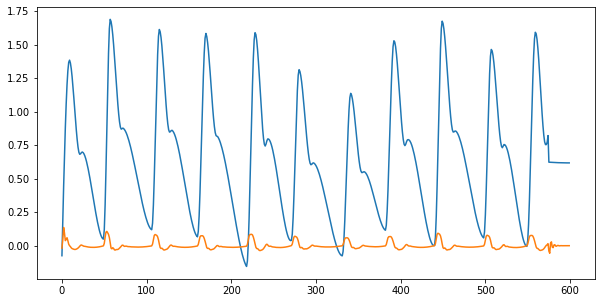

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(ppg)

plt.plot(ppg_f)

##### peak detection 

In [123]:
import heartpy as hp
from heartpy.datautils import rolling_mean
from heartpy.peakdetection import detect_peaks

In [117]:
data, _ = hp.load_exampledata(0)
rol_mean = rolling_mean(ppg, windowsize = 0.75, sample_rate = 60)

In [124]:
wd = detect_peaks(ppg, rol_mean, ma_perc = 20, sample_rate = 60)

In [126]:
wd.keys()

dict_keys(['peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd'])

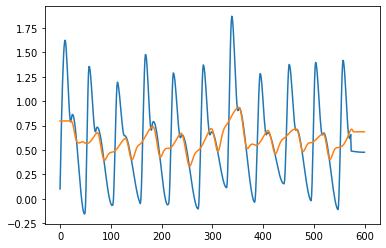

In [121]:
plt.plot(ppg)
plt.plot(rol_mean)

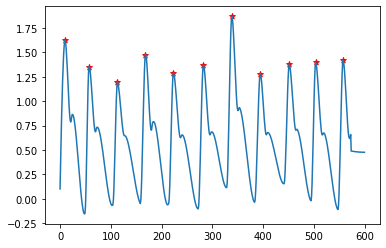

In [135]:
plt.plot(ppg)
plt.scatter(wd['peaklist'],ppg[wd['peaklist']],marker='*',c='r')

##### systolic, diacrotic peak detection 

In [145]:
import neurokit2 as nk

ppg = nk.ppg_simulate(duration=10, sampling_rate=60, heart_rate=70)


In [147]:
signals, info = nk.ppg_process(ppg, sampling_rate=60)

In [171]:
signals_i,info_i = nk.ppg_process(-1*ppg, sampling_rate=60)

In [164]:
info

{'PPG_Peaks': array([ 62, 116, 167, 226, 283, 337, 398, 451, 504, 560]),
 'sampling_rate': 60}

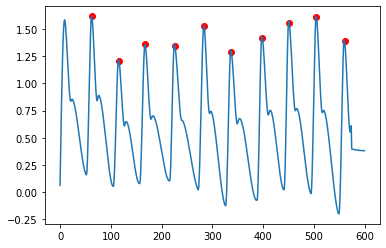

In [166]:
sys_peaks = info['PPG_Peaks']
plt.plot(ppg)
plt.scatter(sys_peaks,ppg[sys_peaks],c='r')

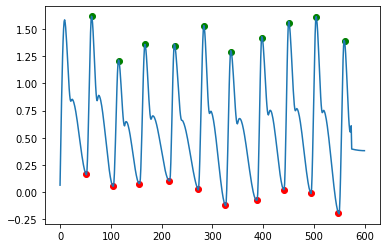

In [174]:
sys_peaks_i = info_i['PPG_Peaks']
plt.plot(ppg)
plt.scatter(sys_peaks_i,ppg[sys_peaks_i],c='r')
plt.scatter(sys_peaks,ppg[sys_peaks],c='g')

##### dataset 

In [299]:
def nrs2class(x,pain_type=3):
    pain = ''
    
    if pain_type == 3:
        if x in [0,1,2,3]:
            pain = 0
        elif x in [4,5]:
            pain = 1
        else:
            pain = 2
    elif pain_type == 2:
        if x in [0,1,2,3]:
            pain = 0
        else:
            pain = 1
    return pain

# __init__
# (paths, y) , name
from torch.nn import functional as F
import os
dir_path = '../data/vital2/'

flist_ = os.listdir(dir_path)

flist_ = [ x for x in flist_ if x.endswith('.vital')]

# fpaths = [os.path.join(dir_path, x) for x in flist]

import pandas as pd
sample_rate = 1/30
op = pd.read_csv(os.path.join(dir_path,'dd_all_simple.csv'))

op = op[['key','pacu_nrs']]

flist = []
for key in op.key:
    
    for f in flist_:
        if f.startswith(key):
            flist.append(f)

fpaths = [os.path.join(dir_path,path) for path in flist]

labels = op.pacu_nrs.map(lambda x: nrs2class(x,2))

# getitem
import vitaldb
import torch
idx = 15

cols = ['Intellivue/PLETH']

vf = vitaldb.VitalFile(fpaths[idx],cols)
x = vf.get_track_samples(cols[0],interval=sample_rate)[:30*60*50]
y = torch.tensor([labels[idx]])
y = F.one_hot(y,num_classes=2)

# Missing value (nearest interpolation)
x = pd.DataFrame(x,columns=['x'])

x = x.fillna(method='ffill').fillna(method='bfill')
x = x['x'].to_numpy()

In [319]:
# systolic peak detection
signals, info = nk.ppg_process(x, sampling_rate=1/sample_rate)

sys_idx = info['PPG_Peaks']

sys_values = signals['PPG_Raw'][sys_idx]

In [401]:
# bottom diastolic peak detection  
bottom_dia_idx = []
for i,idx in enumerate(sys_idx):
    if i == 0: # not sure if a diastolic peak exists
        continue
    pre_idx = sys_idx[i-1]
    min_idx = pre_idx + np.argmin(x[pre_idx:idx])
    bottom_dia_idx.append(min_idx)

In [418]:
# acv_sys & aca_dia
acv_sys = []
aca_dia = []
x=x
for i,idx in enumerate(sys_idx):
    if i == 0: # not sure if a diastolic peak exists
        continue
    pre_idx = sys_idx[i-1]
    
    pre_sys = x[pre_idx]
    sys_val = x[idx]
    dia_val = x[bottom_dia_idx[i-1]]
    
    acv_sys.append(sys_val-pre_sys)
    aca_dia.append(sys_val-dia_val)


acv_sys = np.array(acv_sys)
aca_dia = np.array(aca_dia)

dynamic = acv_sys/aca_dia

In [412]:
pd.DataFrame(acv_sys).describe()

,0
count,2818.000000
mean,-0.002357
std,5.432464
min,-40.390720
25%,-1.294258
50%,0.000000
75%,1.391945
max,78.217346


{'whiskers': [<matplotlib.lines.Line2D at 0x7f586ef1f0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f586ef1f7b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f586ef19da0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f586ef1feb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f586ef03278>],
 'means': []}

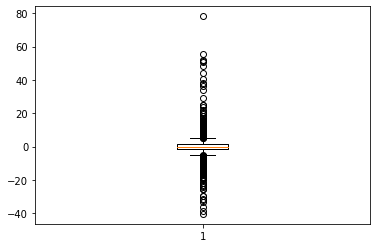

In [414]:
plt.boxplot(acv_sys)

In [413]:
pd.DataFrame(aca_dia).describe()

,0
count,2818.000000
mean,47.936448
std,9.036060
min,1.050060
25%,45.763127
50%,48.791210
75%,50.787550
max,99.853485


(array([  17.,   36.,   70.,  170., 1731.,  682.,   62.,   24.,   21.,
           5.]),
 array([ 1.0500603, 10.930403 , 20.810745 , 30.691088 , 40.57143  ,
        50.451775 , 60.332115 , 70.212456 , 80.092804 , 89.973145 ,
        99.853485 ], dtype=float32),
 <a list of 10 Patch objects>)

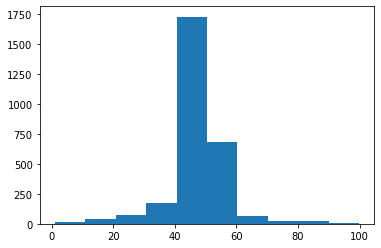

In [416]:
plt.hist(aca_dia)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f586ee65c50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f586ee72358>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f586ee65940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f586ee72a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f586ee72dd8>],
 'means': []}

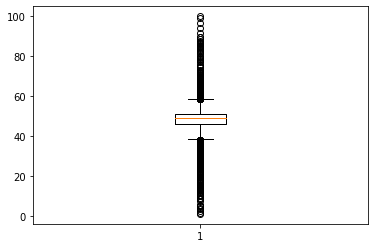

In [415]:
plt.boxplot(aca_dia)

In [397]:
len(bottom_dia_idx),len(peaks_idx)

(2818, 2819)

In [354]:
st = x[:300]

In [360]:
stpeaks = peaks[:10]

In [361]:
p0, p1 = stpeaks[0:2]

In [372]:
p0+np.argmin(x[p0:p1])

57

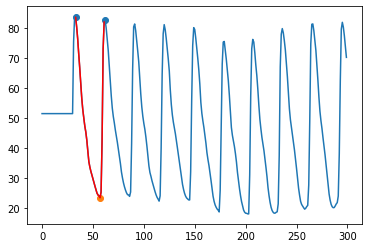

In [373]:
plt.plot(st)
plt.scatter([p0,p1],st[[p0,p1]])
plt.plot(list(range(p0,p1)),x[p0:p1],c='r')
min_idx = p0+np.argmin(x[p0:p1])
plt.scatter([min_idx],st[[min_idx]])

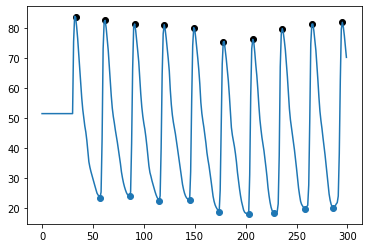

In [394]:
plt.plot(st)
plt.scatter(stpeaks,x[stpeaks],c='black')
plt.scatter(bottom_dia_idx[:9],st[bottom_dia_idx[:9]])

In [ ]:
# method 2. inverse

In [240]:
signals_i, info_i = nk.ppg_process(-1*x, sampling_rate=1/sample_rate)

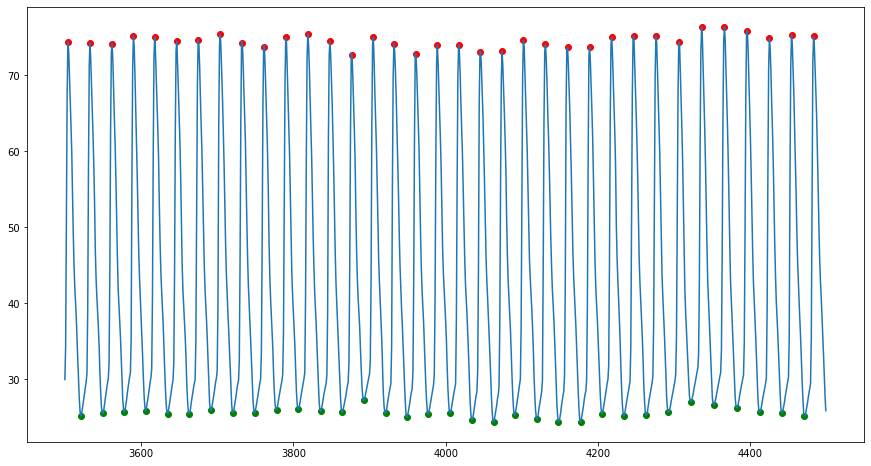

In [273]:
start = 3500#30*60*1
end = 4500#30*60*2  
peaks = info['PPG_Peaks'][(start<info['PPG_Peaks']) & (info['PPG_Peaks']<end)]
peaks_i = info_i['PPG_Peaks'][(start<info_i['PPG_Peaks']) & (info_i['PPG_Peaks']<end)]
 
plt.figure(figsize=(15,8))
plt.plot(signals[['PPG_Raw']][start:end])
plt.scatter(peaks,signals['PPG_Raw'][peaks],c='r')
plt.scatter(peaks_i,signals['PPG_Raw'][peaks_i],c='g')